<a href="https://colab.research.google.com/github/KT2001/Disease_Detection_Technology/blob/master2/DDT_Transfer_learning_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Disease_Detection_Technology

### Introduction

* This Project is to implement Image classification by Cnn to verify if AI could be leveraged in classification of diseases. Implemented the pretrained Model, ResNet50 to train on, radiology scans of diseases such as Covid19, Pneumonia, and Lung Opacity.
* Libraries Used In This Project tensorflow, Matplotlib, numpy, pandas, Keras, PIL, pathlib.
* This Model has achieved 99% Accuracy on Training data, 95% accuracy on Validation data and 95% accuracy on Testing data.
* The Accuracy, F1 Score, Recall and Precision scores are 95.1818611242324 %, 0.9515821860326811, 0.951818611242324 and 0.9525182117751877 respectively.
* This is the First and Basic version Of this Project.

### Research materials used

* M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, M. T. Islam, “Can AI help in screening Viral and COVID-19 pneumonia?” IEEE Access, Vol. 8, 2020, pp. 132665 - 132676 [Paper link](https://ieeexplore.ieee.org/document/9144185)

* Rahman, T., Khandakar, A., Qiblawey, Y., Tahir, A., Kiranyaz, S., Kashem, S.B.A., Islam, M.T., Maadeed, S.A., Zughaier, S.M., Khan, M.S. and Chowdhury, M.E., 2020. Exploring the Effect of Image Enhancement Techniques on COVID-19 Detection using Chest X-ray Images. [Paper link](https://www.sciencedirect.com/science/article/pii/S001048252100113X)

* Narayana Darapaneni, Suma Maram, Harpreet Singh, Syed Subhani, Mandeep Kour, Sathish Nagam, Anwesh Reddy Paduri. "Prediction of COVID-19 using chest X-ray images".[Paper link](https://arxiv.org/abs/2204.03849v1)

* This notebook also took inspiiration from the *Covid-19 Radiology | VGG19| f1-score: 95%* by AHMED HAFEZ.[Link to the notebook](https://www.kaggle.com/code/ahmedtronic/covid-19-radiology-vgg19-f1-score-95)

### Dataset

**COVID-19 RADIOGRAPHY DATABASE (Winner of the COVID-19 Dataset Award by Kaggle Community)**

A team of researchers from Qatar University, Doha, Qatar, and the University of Dhaka, Bangladesh along with their collaborators from Pakistan and Malaysia in collaboration with medical doctors have created a database of chest X-ray images for COVID-19 positive cases along with Normal and Viral Pneumonia images. This COVID-19, normal, and other lung infection dataset is released in stages. In the first release, we have released 219 COVID-19, 1341 normal, and 1345 viral pneumonia chest X-ray (CXR) images. In the first update, we have increased the COVID-19 class to 1200 CXR images. In the 2nd update, we have increased the database to 3616 COVID-19 positive cases along with 10,192 Normal, 6012 Lung Opacity (Non-COVID lung infection), and 1345 Viral Pneumonia images and corresponding lung masks. We will continue to update this database as soon as we have new x-ray images for COVID-19 pneumonia patients.

The link to the dataset is [here](https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database)





In [1]:
!nvidia-smi

Thu Jun  1 18:08:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Importing neccesarry Libraries**

In [2]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools      

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report
from sklearn.utils import class_weight
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# **Extracting the files**

In [ ]:
!unzip /content/drive/MyDrive/DDT/Dataset/Covid_19_Radiography.zip

In [4]:
# generate data paths
def define_paths(root_folder):
  filepaths = []
  labels = []

  dir = os.listdir(root_folder)

  for files in dir:
    file = os.path.join(root_folder, files)
    # check the folders from main directory. If there are another files, ignore them
    if pathlib.Path(file).suffix != '':
      continue
    
    filelist = os.listdir(file)
    for paths in filelist:
      fpaths = os.path.join(file, paths)
      # check if there are another folders
      if pathlib.Path(fpaths).suffix == '':
        # check for masks
        if pathlib.Path(fpaths).parts[-1] == 'masks':
          continue
        else:
          final_file = os.listdir(fpaths)
          for f in final_file:
            image_paths = os.path.join(fpaths, f)
            filepaths.append(image_paths)
            labels.append(files)
      else:
        filepaths.append(fpaths)
        labels.append(files)

  return filepaths, labels

In [5]:
filepaths, labels = define_paths('/content/COVID-19_Radiography_Dataset')

In [6]:
# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

In [7]:
df=define_df(filepaths, labels)
df.head()

,filepaths,labels
0,/content/COVID-19_Radiography_Dataset/COVID/im...,COVID
1,/content/COVID-19_Radiography_Dataset/COVID/im...,COVID
2,/content/COVID-19_Radiography_Dataset/COVID/im...,COVID
3,/content/COVID-19_Radiography_Dataset/COVID/im...,COVID
4,/content/COVID-19_Radiography_Dataset/COVID/im...,COVID


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21165 entries, 0 to 21164
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  21165 non-null  object
 1   labels     21165 non-null  object
dtypes: object(2)
memory usage: 330.8+ KB


In [9]:
# view distribution of different classes
def show_number_of_classes_bar(df):
  plt.figure(figsize=(25, 25))
  values = df['labels'].value_counts()
  plt.xlabel("number of images available")
  plt.ylabel("Image dataset")
  values.plot(kind = 'barh', color='Red', capsize=10)
  #plt.barh(flowers, values, color = 'Red', capsize = 10)

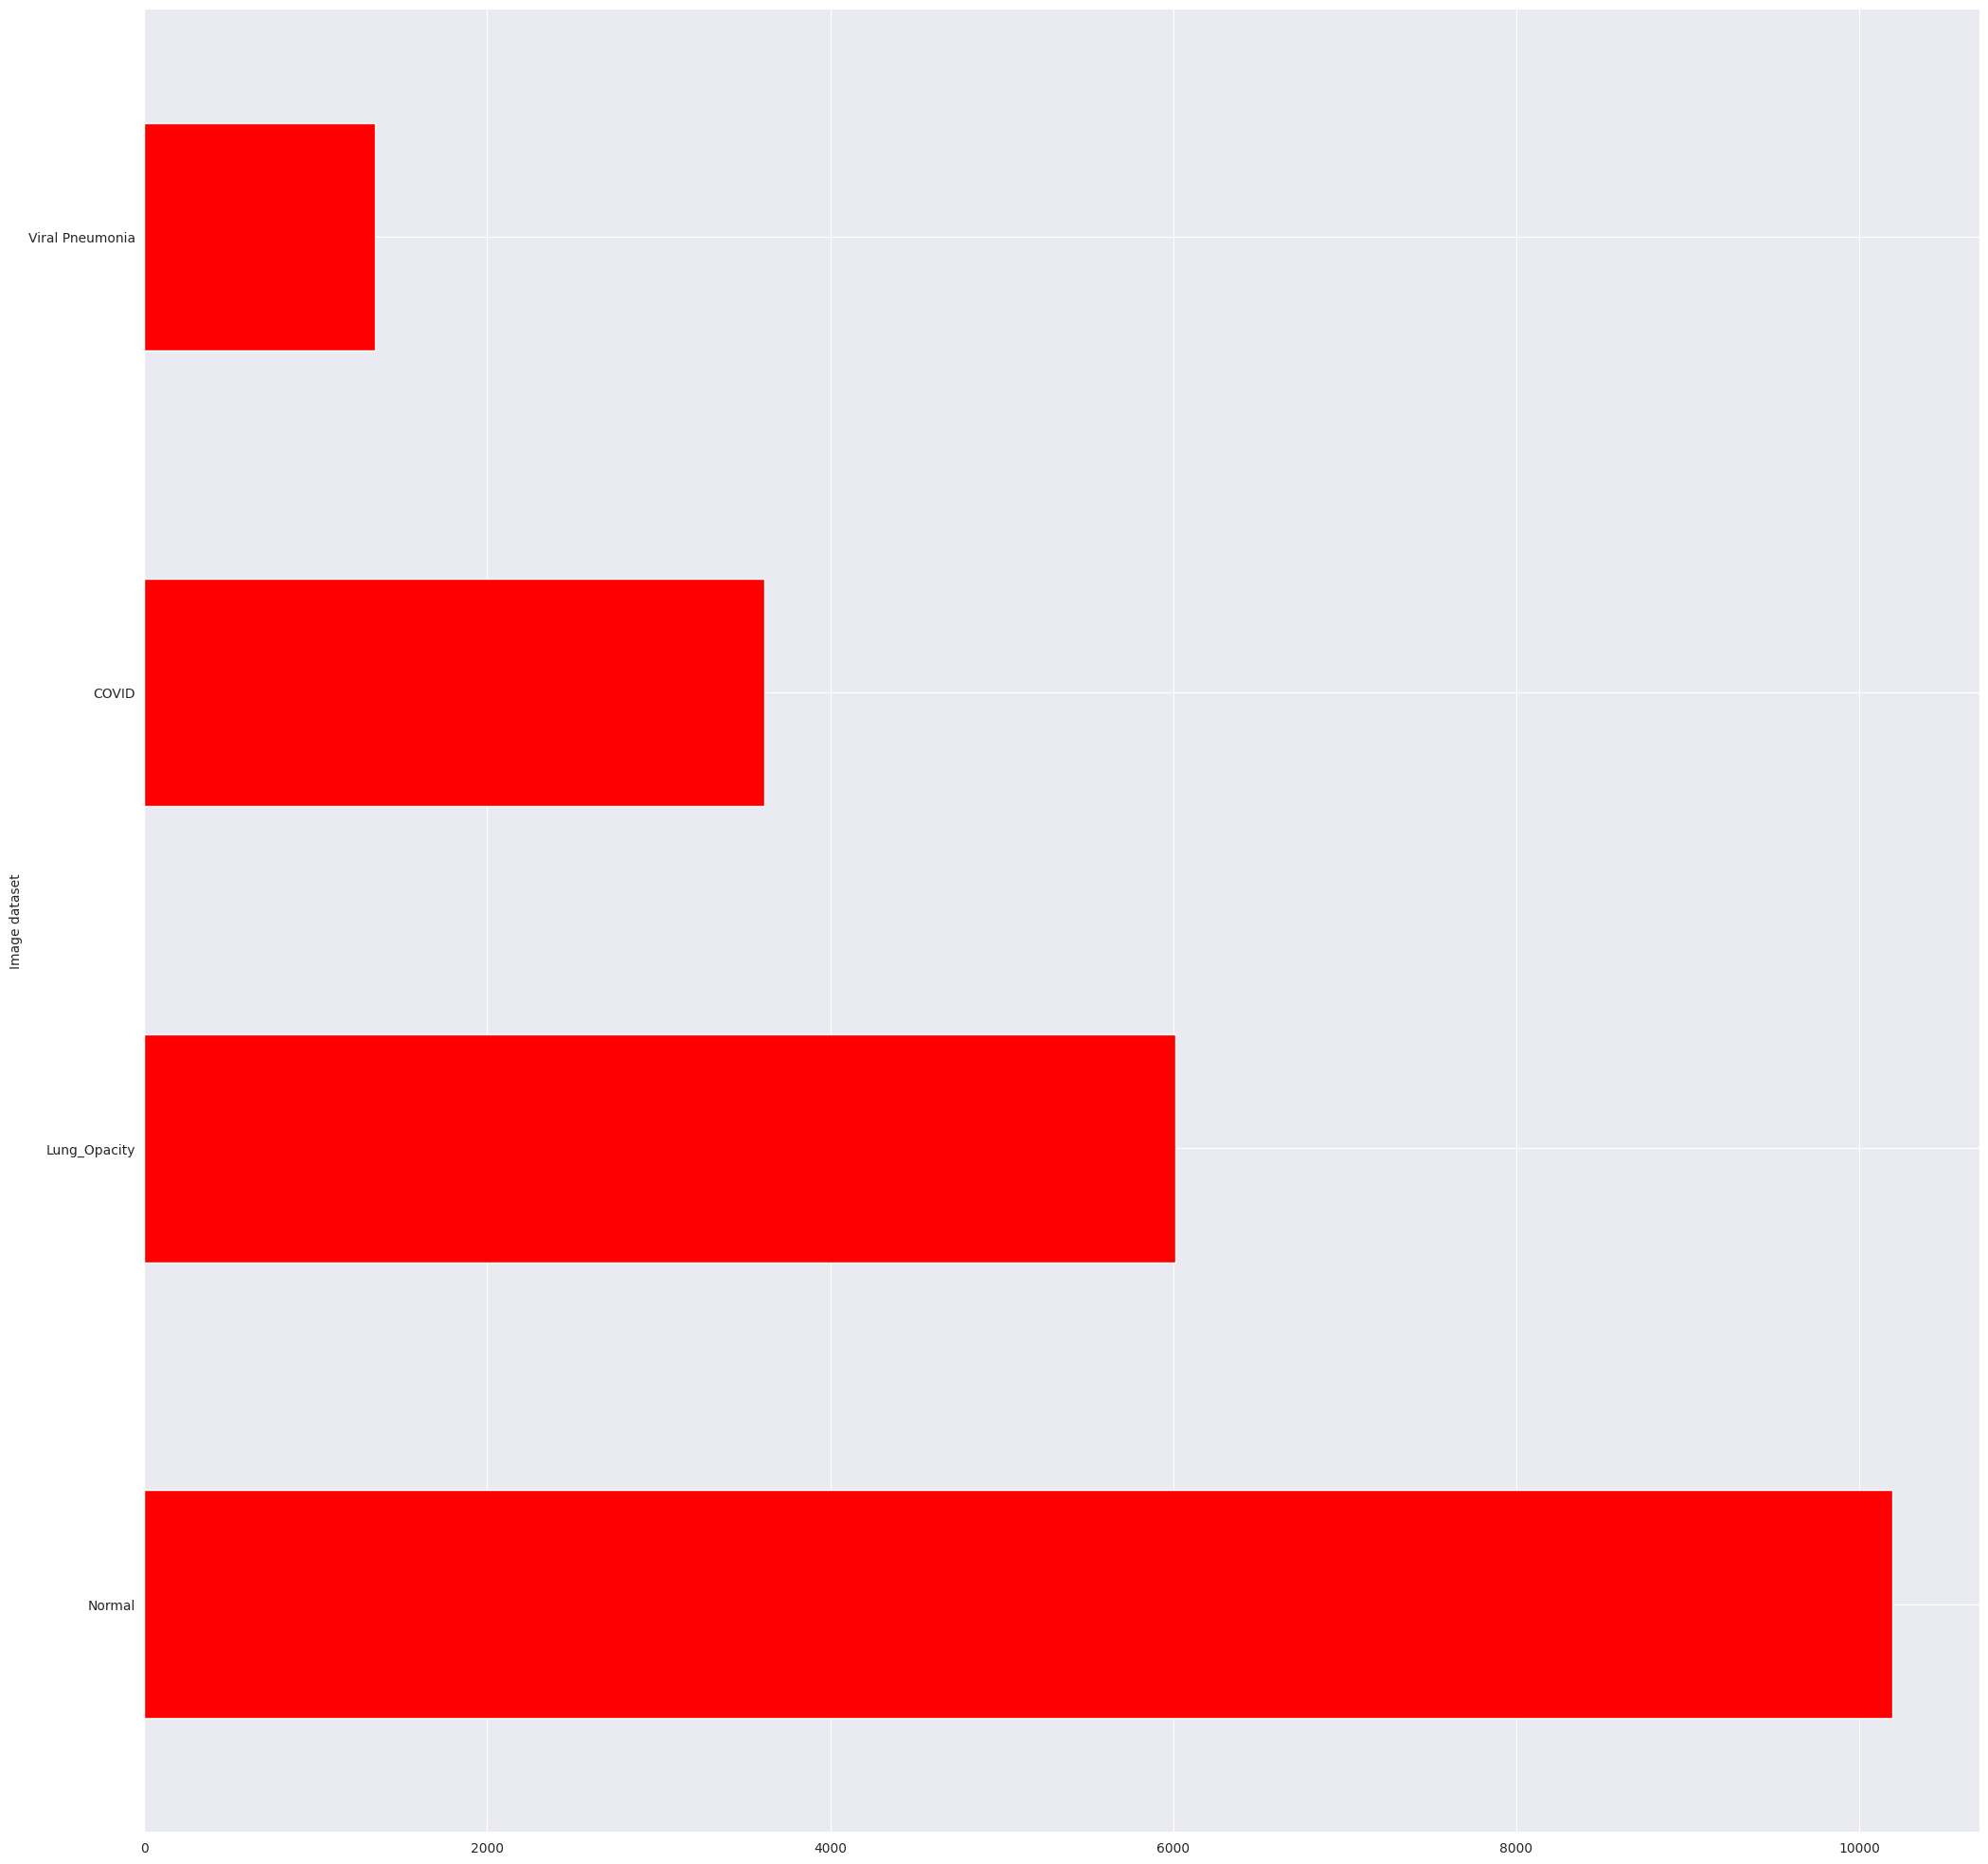

In [10]:
show_number_of_classes_bar(df)

We can see that classes are imbalanced but the gap is extremely big between number of images per class.

# **Preprocessing the images**

In [11]:
# Split dataframe to train, valid, and test
def split_data(df):
  strat = df['labels']
  train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)
  # valid and test dataframe
  strat = dummy_df['labels']
  valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)
  return train_df, valid_df, test_df

In [12]:
train_df, valid_df, test_df = split_data(df)

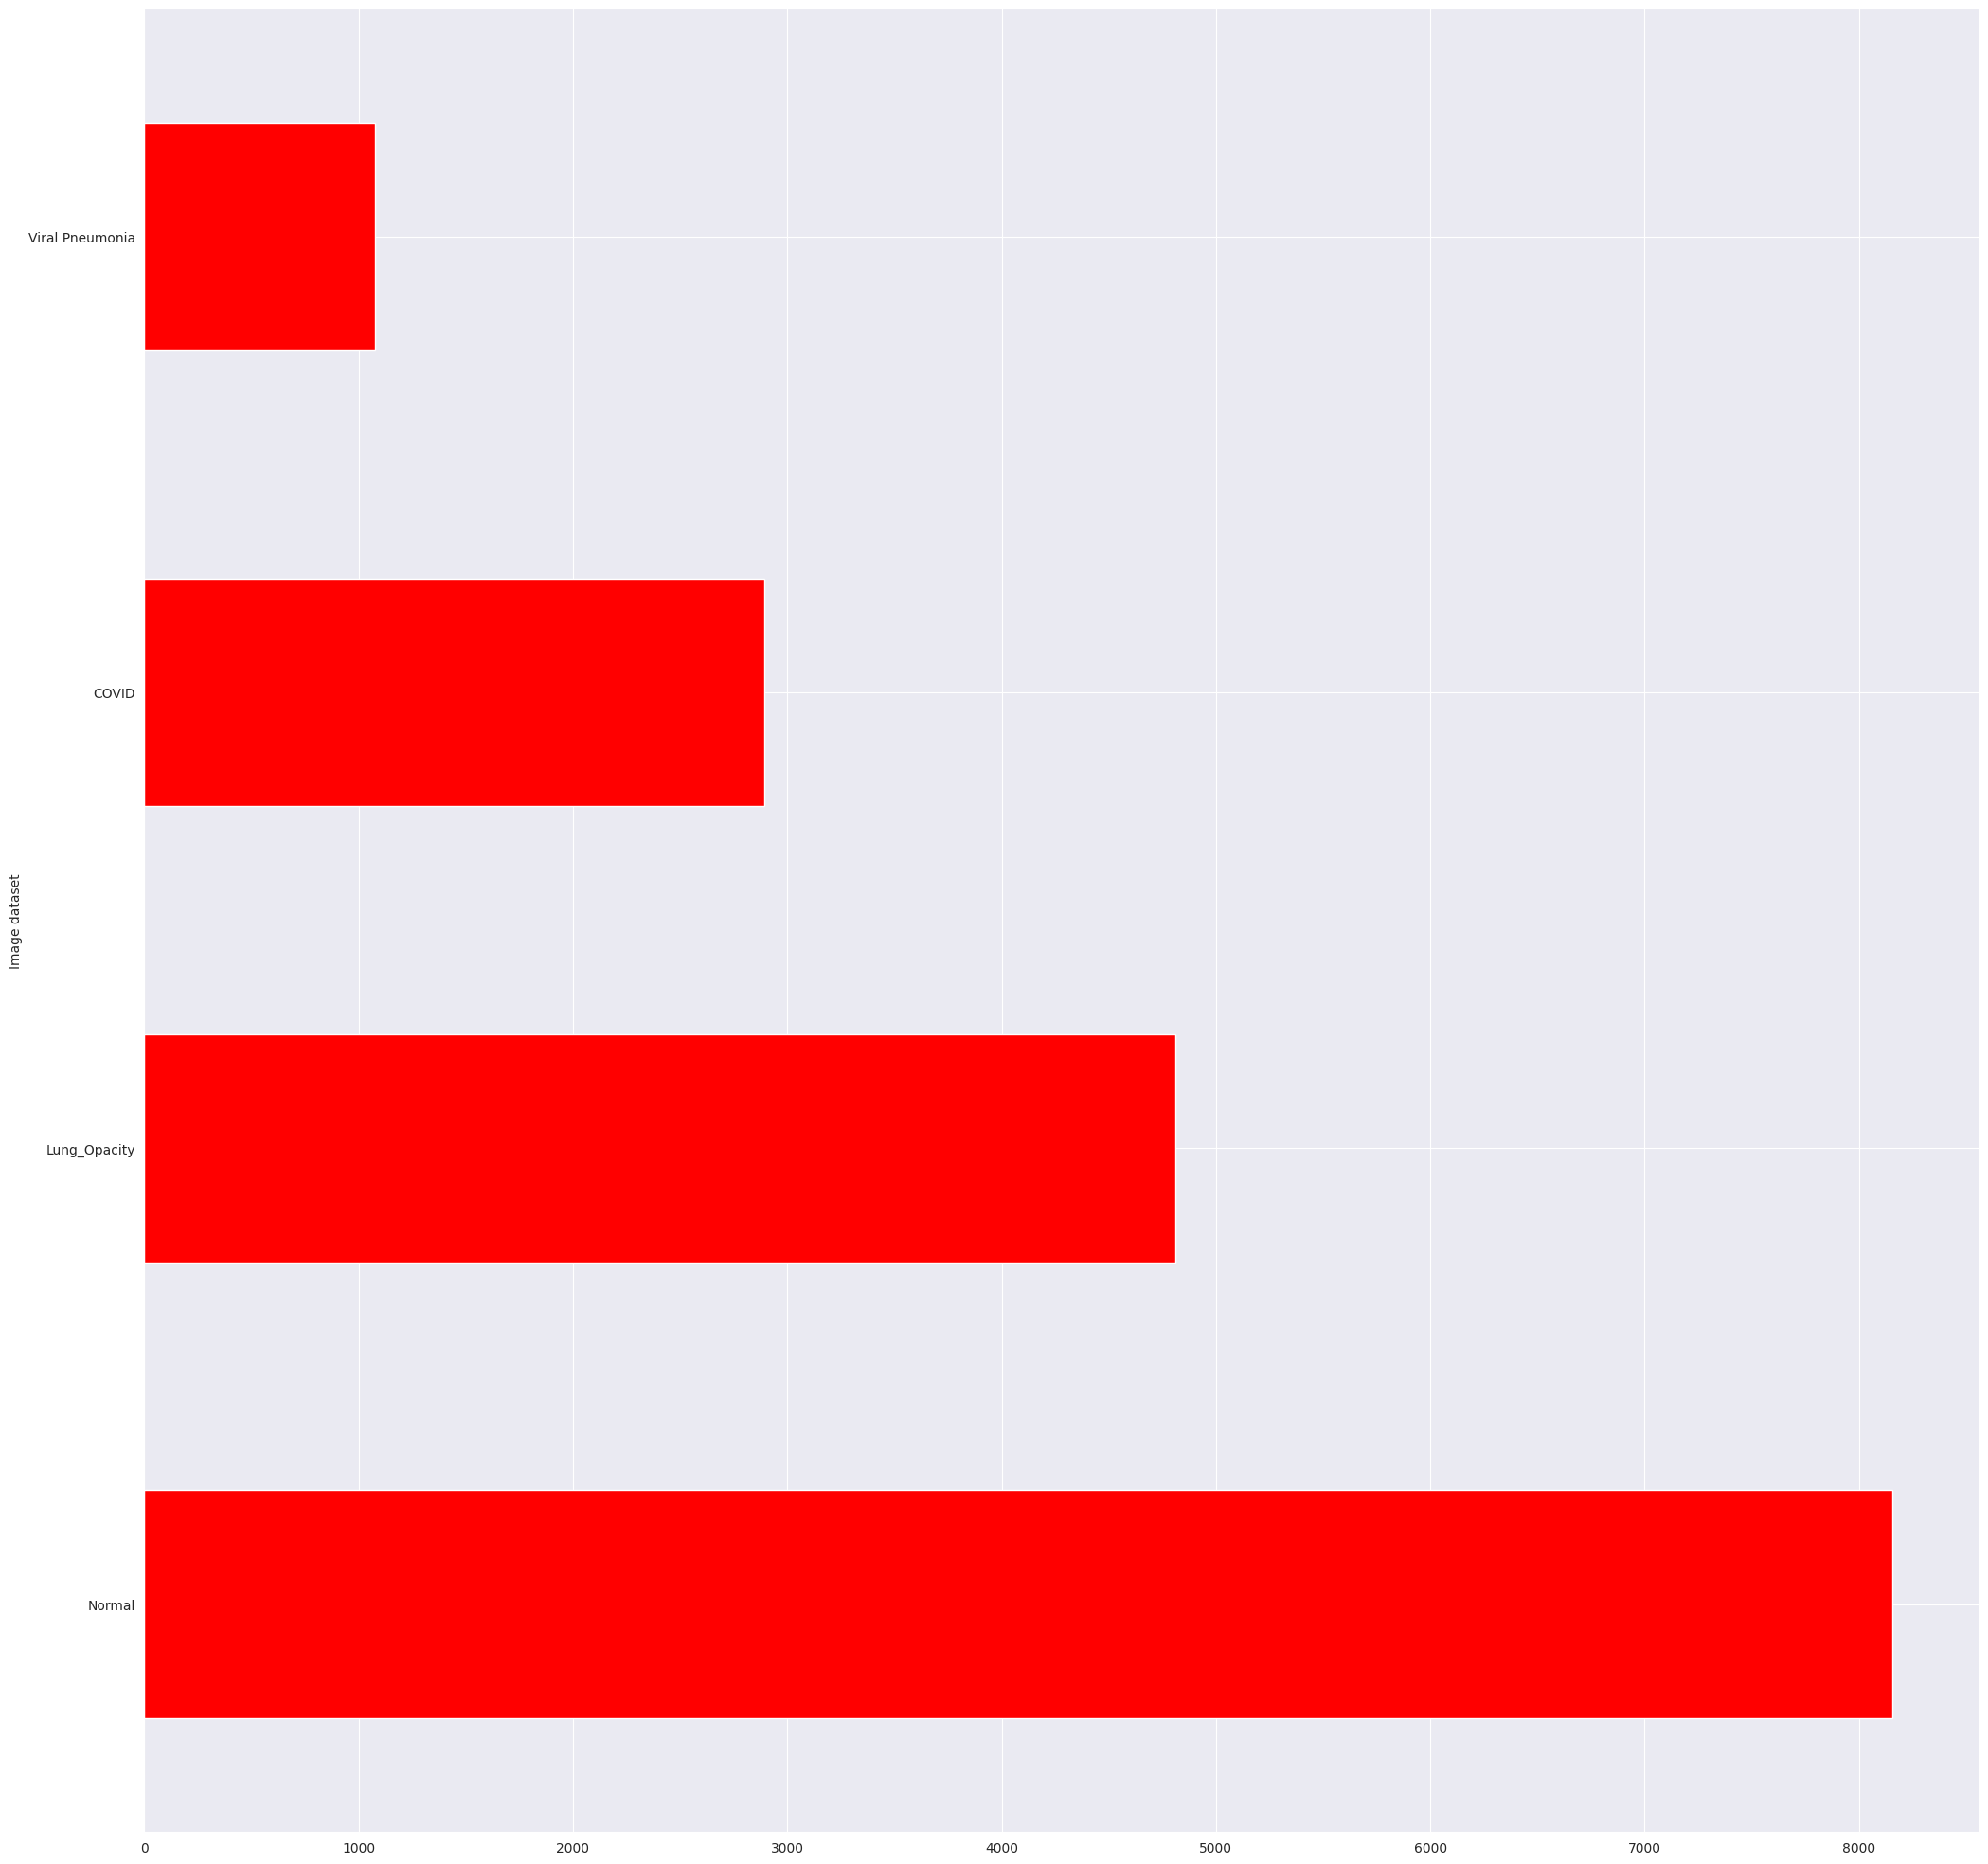

In [13]:
show_number_of_classes_bar(train_df)

In [15]:
def Augment(df, n, working_dir, img_size):
    print('Initial length of dataframe is ', len(df))

    augment_dir = os.path.join(working_dir, 'AuG')  # directory to store augmented images
    os.mkdir(augment_dir)

    for label in df['labels'].unique():
        dir_path = os.path.join(augment_dir, label)
        os.mkdir(dir_path)  # make class directories within aug directory

    # Counter variable for total augmented images
    total = 0
    rotation_translation_gen = ImageDataGenerator(rotation_range=10, width_shift_range=.1,
                                                 height_shift_range=.1)

    translation_gen = ImageDataGenerator(width_shift_range=.1,
                                         height_shift_range=.1)

    # Define a dictionary mapping class labels to their corresponding augmentations
    class_augmentations = {
        'COVID': rotation_translation_gen,
        'Lung_Opacity': rotation_translation_gen,
        'Normal': translation_gen,
        'Viral Pneumonia': translation_gen
        # Add more classes and their augmentations as needed
    }

    groups = df.groupby('labels')  # store images grouped by class

    for label, datagen in class_augmentations.items():
        group = groups.get_group(label)  # store image paths for a particular label
        number_of_images = len(group)  # determine how many samples there are in this class

        if number_of_images < n:  # if the class has less than target number of images
            aug_img_count = 0  # counter variable for number of aug images created for that class
            difference = n - number_of_images  # number of augmented images to create

            if difference > 600:
                difference = 600  # Limit the number of augmented images to add to 500

            target_dir = os.path.join(augment_dir, label)  # define where to write the images
            print(f'For {label} creating {difference} augmented images. ', end='')
            aug_gen = datagen.flow_from_dataframe(group, x_col='filepaths', y_col=None, target_size=img_size,
                                                  class_mode=None, batch_size=1, shuffle=False,
                                                  save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                                  save_format='png')

            while aug_img_count < difference:
                # Generate augmented images and save them
                batch_images = next(aug_gen)
                aug_img_count += 1
                total += 1
                print(f'{aug_img_count}/{difference}', end=' ')
            print('\n')

    print('Total augmented images created: ', total)

In [ ]:
'''
# optional code cell, as it has been noticed, that the score is still above 90%
def Augment(df, n, working_dir, img_size):
  print('Initial length of dataframe is ', len(df))
  
  
  augment_dir=os.path.join(working_dir, 'aug')# directory to store augmented images
  os.mkdir(augment_dir)        
  
  
  for label in df['labels'].unique():    
      dir_path=os.path.join(augment_dir,label)    
      os.mkdir(dir_path) # make class directories within aug directory
  
  
  #counter variable for total augmented images
  total=0
  rotation_translation_gen=ImageDataGenerator(rotation_range=10, width_shift_range=.1,
                                height_shift_range=.1)
  
  translation_gen=ImageDataGenerator(width_shift_range=.1,
                                height_shift_range=.1)
  
  # Define a dictionary mapping class labels to their corresponding augmentations
  class_augmentations = {
    'COVID': rotation_translation_gen,
    'Lung_Opacity': rotation_translation_gen,
    'Normal': translation_gen,
    'Viral Pneumonia': translation_gen
    # Add more classes and their augmentations as needed
  }

  groups=df.groupby('labels') # store images grouped by class
  
  for label, datagen in class_augmentations.items():            
      group=groups.get_group(label)  # store image paths for a particular label
      number_of_images=len(group)   # determine how many samples there are in this class        
      if number_of_images< n: # if the class has less than target number of images
          aug_img_count=0 # counter variable for number of aug images created for that class
          difference=n - number_of_images  # number of augmented images to create
          target_dir=os.path.join(augment_dir, label)  # define where to write the images
          print(f'For {label} creating {difference} augmented images. ',end='')
          #print(msg, '\r', end='') # prints over on the same line
          aug_gen=datagen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=img_size,
                                          class_mode=None, batch_size=1, shuffle=False, 
                                          save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                          save_format='png')
          print("Hello")
          while aug_img_count < difference:
              # Generate augmented images and save them
              batch_images = next(aug_gen)
              aug_img_count += 1
              total += 1
              print(f'{aug_img_count}/{difference}', end=' ')
          print('\n')
  print('Total augmented images created: ', total)
'''

In [16]:
n=8000 # number of samples in each class
working_dir=r'./' # directory to store augmented images
img_size=(224,224) # size of augmented images, we will be using this variable as a universal variable
Augment(train_df, n, working_dir, img_size)    

Initial length of dataframe is  16932
For COVID creating 600 augmented images. Found 2893 validated image filenames.
1/600 2/600 3/600 4/600 5/600 6/600 7/600 8/600 9/600 10/600 11/600 12/600 13/600 14/600 15/600 16/600 17/600 18/600 19/600 20/600 21/600 22/600 23/600 24/600 25/600 26/600 27/600 28/600 29/600 30/600 31/600 32/600 33/600 34/600 35/600 36/600 37/600 38/600 39/600 40/600 41/600 42/600 43/600 44/600 45/600 46/600 47/600 48/600 49/600 50/600 51/600 52/600 53/600 54/600 55/600 56/600 57/600 58/600 59/600 60/600 61/600 62/600 63/600 64/600 65/600 66/600 67/600 68/600 69/600 70/600 71/600 72/600 73/600 74/600 75/600 76/600 77/600 78/600 79/600 80/600 81/600 82/600 83/600 84/600 85/600 86/600 87/600 88/600 89/600 90/600 91/600 92/600 93/600 94/600 95/600 96/600 97/600 98/600 99/600 100/600 101/600 102/600 103/600 104/600 105/600 106/600 107/600 108/600 109/600 110/600 111/600 112/600 113/600 114/600 115/600 116/600 117/600 118/600 119/600 120/600 121/600 122/600 123/600 124/600

In [17]:
aug_file, aug_labels = define_paths('/content/AuG')

In [18]:
aug_df = define_df(aug_file, aug_labels)

In [19]:
aug_df.head()

,filepaths,labels
0,/content/AuG/COVID/aug-_231_3099196.png,COVID
1,/content/AuG/COVID/aug-_19_8905275.png,COVID
2,/content/AuG/COVID/aug-_192_1073604.png,COVID
3,/content/AuG/COVID/aug-_73_6032528.png,COVID
4,/content/AuG/COVID/aug-_225_4467709.png,COVID


In [20]:
aug_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  1800 non-null   object
 1   labels     1800 non-null   object
dtypes: object(2)
memory usage: 28.2+ KB


In [21]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16932 entries, 1993 to 20735
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  16932 non-null  object
 1   labels     16932 non-null  object
dtypes: object(2)
memory usage: 396.8+ KB


In [22]:
new_train_df = pd.merge(train_df, aug_df, how='outer')

In [23]:
new_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18732 entries, 0 to 18731
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  18732 non-null  object
 1   labels     18732 non-null  object
dtypes: object(2)
memory usage: 439.0+ KB


In [24]:
def create_gens (train_df, valid_df, test_df, batch_size):
    '''
    This function takes train, validation, and test dataframe and fit them into image data generator, because model takes data from image data generator.
    Image data generator converts images into tensors. '''

    # define model parameters
    img_size = (224, 224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

In [25]:
train_gen, valid_gen, test_gen = create_gens(new_train_df, valid_df, test_df, batch_size=16)

Found 18732 validated image filenames belonging to 4 classes.
Found 2116 validated image filenames belonging to 4 classes.
Found 2117 validated image filenames belonging to 4 classes.


In [26]:
def show_images(gen):
    '''
    This function take the data generator and show sample of the images
    '''

    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

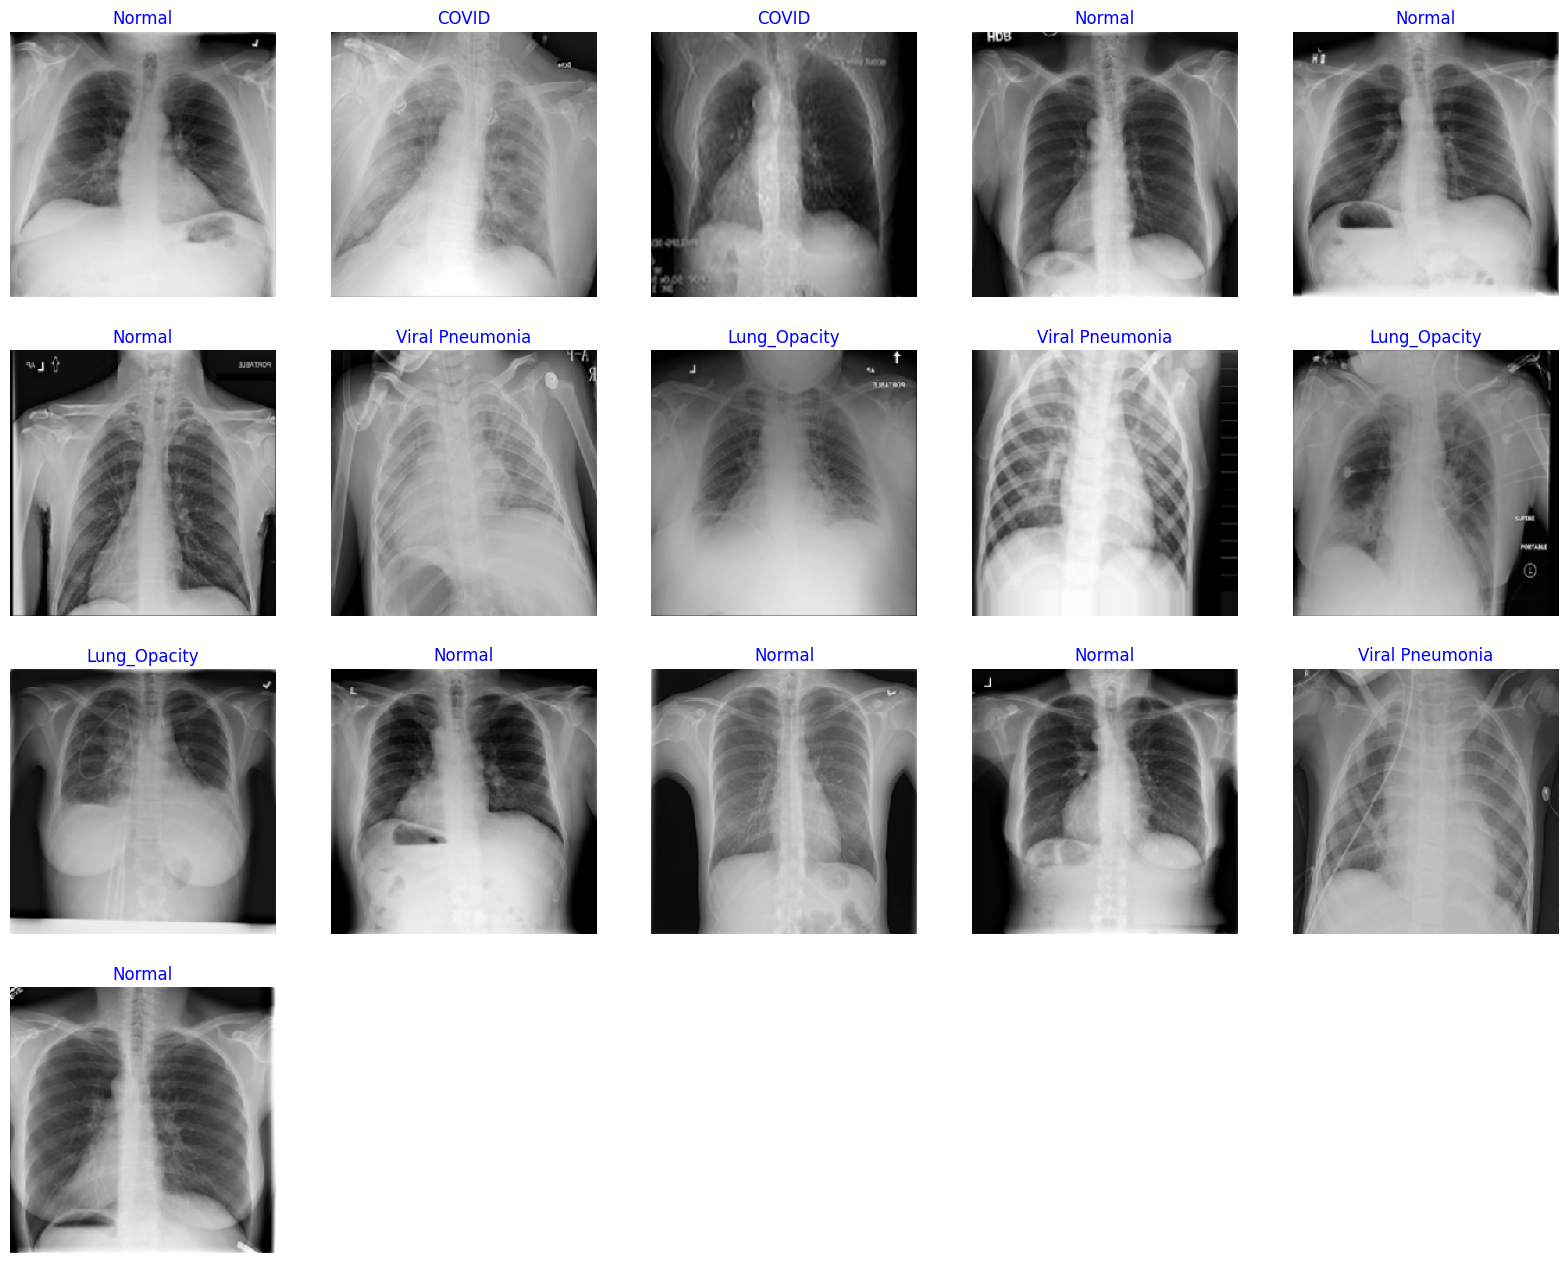

In [27]:
show_images(train_gen)

In [28]:
class MyCallback(keras.callbacks.Callback):
  '''
  This class allows the user to hault the number if epochs as per user needs
  '''
  def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
      super(MyCallback, self).__init__()
      self.model = model
      self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
      self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
      self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
      self.factor = factor # factor by which to reduce the learning rate
      self.batches = batches # number of training batch to run per epoch
      self.epochs = epochs
      self.ask_epoch = ask_epoch
      self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training

      # callback variables
      self.count = 0 # how many times lr has been reduced without improvement
      self.stop_count = 0
      self.best_epoch = 1   # epoch with the lowest loss
      self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initial learning rate and save it
      self.highest_tracc = 0.0 # set highest training accuracy to 0 initially
      self.lowest_vloss = np.inf # set lowest validation loss to infinity initially
      self.best_weights = self.model.get_weights() # set best weights to model's initial weights
      self.initial_weights = self.model.get_weights()   # save initial weights if they have to get restored

  # Define a function that will run when train begins
  def on_train_begin(self, logs= None):
      msg = 'Do you want model asks you to halt the training [y/n] ?'
      print(msg)
      ans = input('')
      if ans in ['Y', 'y']:
          self.ask_permission = 1
      elif ans in ['N', 'n']:
          self.ask_permission = 0

      msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
      print(msg)
      self.start_time = time.time()


  def on_train_end(self, logs= None):
      stop_time = time.time()
      tr_duration = stop_time - self.start_time
      hours = tr_duration // 3600
      minutes = (tr_duration - (hours * 3600)) // 60
      seconds = tr_duration - ((hours * 3600) + (minutes * 60))

      msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
      print(msg)

      # set the weights of the model to the best weights
      self.model.set_weights(self.best_weights)


  def on_train_batch_end(self, batch, logs= None):
      # get batch accuracy and loss
      acc = logs.get('accuracy') * 100
      loss = logs.get('loss')

      # prints over on the same line to show running batch count
      msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
      print(msg, '\r', end= '')


  def on_epoch_begin(self, epoch, logs= None):
      self.ep_start = time.time()


  # Define method runs on the end of each epoch
  def on_epoch_end(self, epoch, logs= None):
      ep_end = time.time()
      duration = ep_end - self.ep_start

      lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
      current_lr = lr
      acc = logs.get('accuracy')  # get training accuracy
      v_acc = logs.get('val_accuracy')  # get validation accuracy
      loss = logs.get('loss')  # get training loss for this epoch
      v_loss = logs.get('val_loss')  # get the validation loss for this epoch

      if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
          monitor = 'accuracy'
          if epoch == 0:
              pimprov = 0.0
          else:
              pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

          if acc > self.highest_tracc: # training accuracy improved in the epoch
              self.highest_tracc = acc # set new highest training accuracy
              self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
              self.count = 0 # set count to 0 since training accuracy improved
              self.stop_count = 0 # set stop counter to 0
              if v_loss < self.lowest_vloss:
                  self.lowest_vloss = v_loss
              self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

          else:
              # training accuracy did not improve check if this has happened for patience number of epochs
              # if so adjust learning rate
              if self.count >= self.patience - 1: # lr should be adjusted
                  lr = lr * self.factor # adjust the learning by factor
                  tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                  self.count = 0 # reset the count to 0
                  self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                  self.count = 0 # reset counter
                  if v_loss < self.lowest_vloss:
                      self.lowest_vloss = v_loss
              else:
                  self.count = self.count + 1 # increment patience counter

      else: # training accuracy is above threshold so adjust learning rate based on validation loss
          monitor = 'val_loss'
          if epoch == 0:
              pimprov = 0.0

          else:
              pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss

          if v_loss < self.lowest_vloss: # check if the validation loss improved
              self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
              self.best_weights = self.model.get_weights() # validation loss improved so save the weights
              self.count = 0 # reset count since validation loss improved
              self.stop_count = 0
              self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch

          else: # validation loss did not improve
              if self.count >= self.patience - 1: # need to adjust lr
                  lr = lr * self.factor # adjust the learning rate
                  self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                  self.count = 0 # reset counter
                  tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer

              else:
                  self.count = self.count + 1 # increment the patience counter

              if acc > self.highest_tracc:
                  self.highest_tracc = acc

      msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
      print(msg)

      if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
          msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
          print(msg)
          self.model.stop_training = True # stop training

      else:
          if self.ask_epoch != None and self.ask_permission != 0:
              if epoch + 1 >= self.ask_epoch:
                  msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                  print(msg)

                  ans = input('')
                  if ans == 'H' or ans == 'h':
                      msg = f'training has been halted at epoch {epoch + 1} due to user input'
                      print(msg)
                      self.model.stop_training = True # stop training

                  else:
                      try:
                          ans = int(ans)
                          self.ask_epoch += ans
                          msg = f' training will continue until epoch {str(self.ask_epoch)}'
                          print(msg)
                          msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                          print(msg)

                      except Exception:
                          print('Invalid')

# **Building the model and Evaluating the result**

In [29]:
#import tensorflow_hub as hub
    
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
#keras_layer = hub.KerasLayer('https://kaggle.com/models/google/resnet-v2/frameworks/TensorFlow2/variations/50-classification/versions/2')
base_model = tf.keras.applications.resnet50.ResNet50(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 4)                 8196      
                                                                 
Total params: 23,595,908
Trainable params: 23,542,788
Non-trainable params: 53,120
_________________________________________________________________


In [30]:
batch_size = 16   # set batch size for training
epochs = 100   # number of all epochs in training
patience = 3   #number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 10   # number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9   # if train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5   # factor to reduce lr by
ask_epoch = 5   # number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))    # number of training batch to run per epoch

callbacks = [MyCallback(model= model, patience= patience, stop_patience= stop_patience, threshold= threshold,
            factor= factor, batches= batches, epochs= epochs, ask_epoch= ask_epoch )]

In [31]:
history = model.fit(x= train_gen, epochs= epochs, verbose= 0, callbacks= callbacks,
                    validation_data= valid_gen, validation_steps= None, shuffle= False)

Do you want model asks you to halt the training [y/n] ?
y
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /100    1.339   82.661   0.87716  76.749   0.00100  0.00100  accuracy     0.00    263.46 
 2 /100    0.482   88.928   0.77961  66.493   0.00100  0.00100  accuracy     7.58    218.15 
 3 /100    0.337   90.807   1.22229  62.051   0.00100  0.00100  val_loss    -56.78   215.62 
 4 /100    0.240   92.788   0.88298  72.921   0.00100  0.00100  val_loss    -13.26   219.06 
 5 /100    0.210   93.487   0.64244  77.363   0.00100  0.00100  val_loss    17.59    218.45 
enter H to halt training or an integer for number of epochs to run then ask again
15
 training will continue until epoch 20
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 6 /100    0.184   94.042   0.49655  82.987   0.00100  0.00100  val_loss    22.71    219.01 
 7 /100    0.152   94.886   1.26158  77.646   0.00100  0.00100  val_loss   -

In [32]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

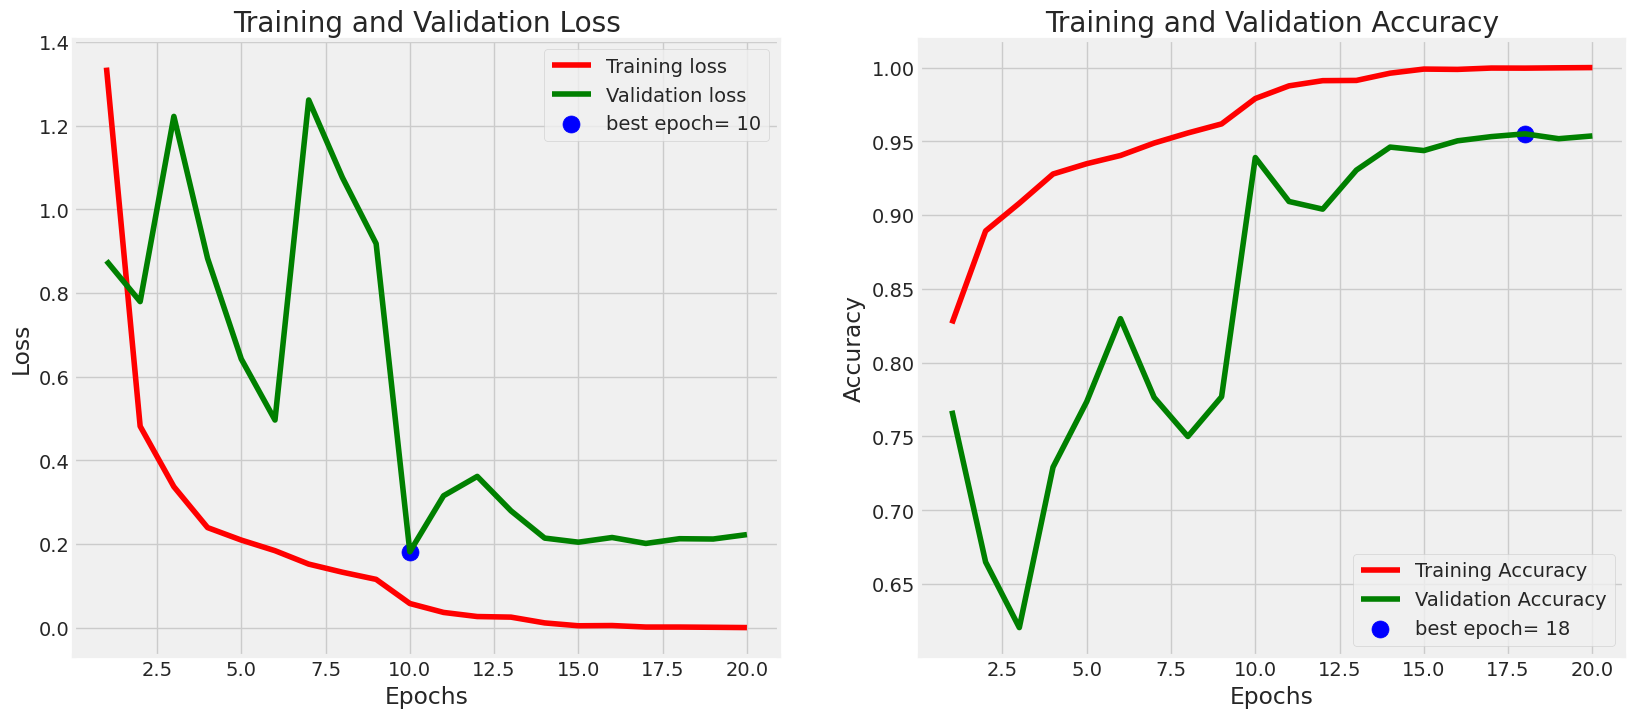

In [33]:
plot_training(history)

In [34]:
def supervised_metrics(y_true, y_pred):
    """Meterics for a Supervised Learning model:"""
    print("Accuracy : {} %".format(accuracy_score(y_true, y_pred)*100))
    print("F1 Score : {}".format(f1_score(y_true, y_pred, average='weighted')))
    print("Recall : {}".format(recall_score(y_true, y_pred, average='weighted')))
    print("Precision : {}".format(precision_score(y_true, y_pred, average='weighted')))

In [35]:
y_pred = []
y_true=test_gen.labels
classes=list(test_gen.class_indices.keys())
class_count=len(classes)
errors=0 #store errors
preds=model.predict(test_gen, verbose=1)
    
tests=len(preds)    
    
#loop to check the number of errors    
for i, j in enumerate(preds):        
    pred_index=np.argmax(j)         
    true_index=test_gen.labels[i]      
    if pred_index != true_index: # is predicted label=true label?                                           
        errors=errors + 1
    y_pred.append(pred_index)

ypred=np.array(y_pred)
ytrue=np.array(y_true)

supervised_metrics(y_true, y_pred)

29/29 [==============================] - 12s 271ms/step
Accuracy : 93.2451582427964 %
F1 Score : 0.932032213836381
Recall : 0.9324515824279641
Precision : 0.9330140142499469


In [36]:
def confusion_matrix_plot(y_true, y_pred, figsize=(30,30)):
  """"Confusion Matrix for true values and predicted values"""
  cm = metrics.confusion_matrix(y_true, y_pred)
  cm = cm.astype('float') / cm.sum(axis=1)
  plt.figure(figsize = figsize)
  plt.tight_layout()
  tick_marks = np.arange(len(classes))
  sns.heatmap(cm, annot=True, cmap="crest")
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes, rotation=45)

  plt.xlabel('Predicted label')
  plt.ylabel('True label')
  plt.title('Confusion Matrix')
  plt.show()

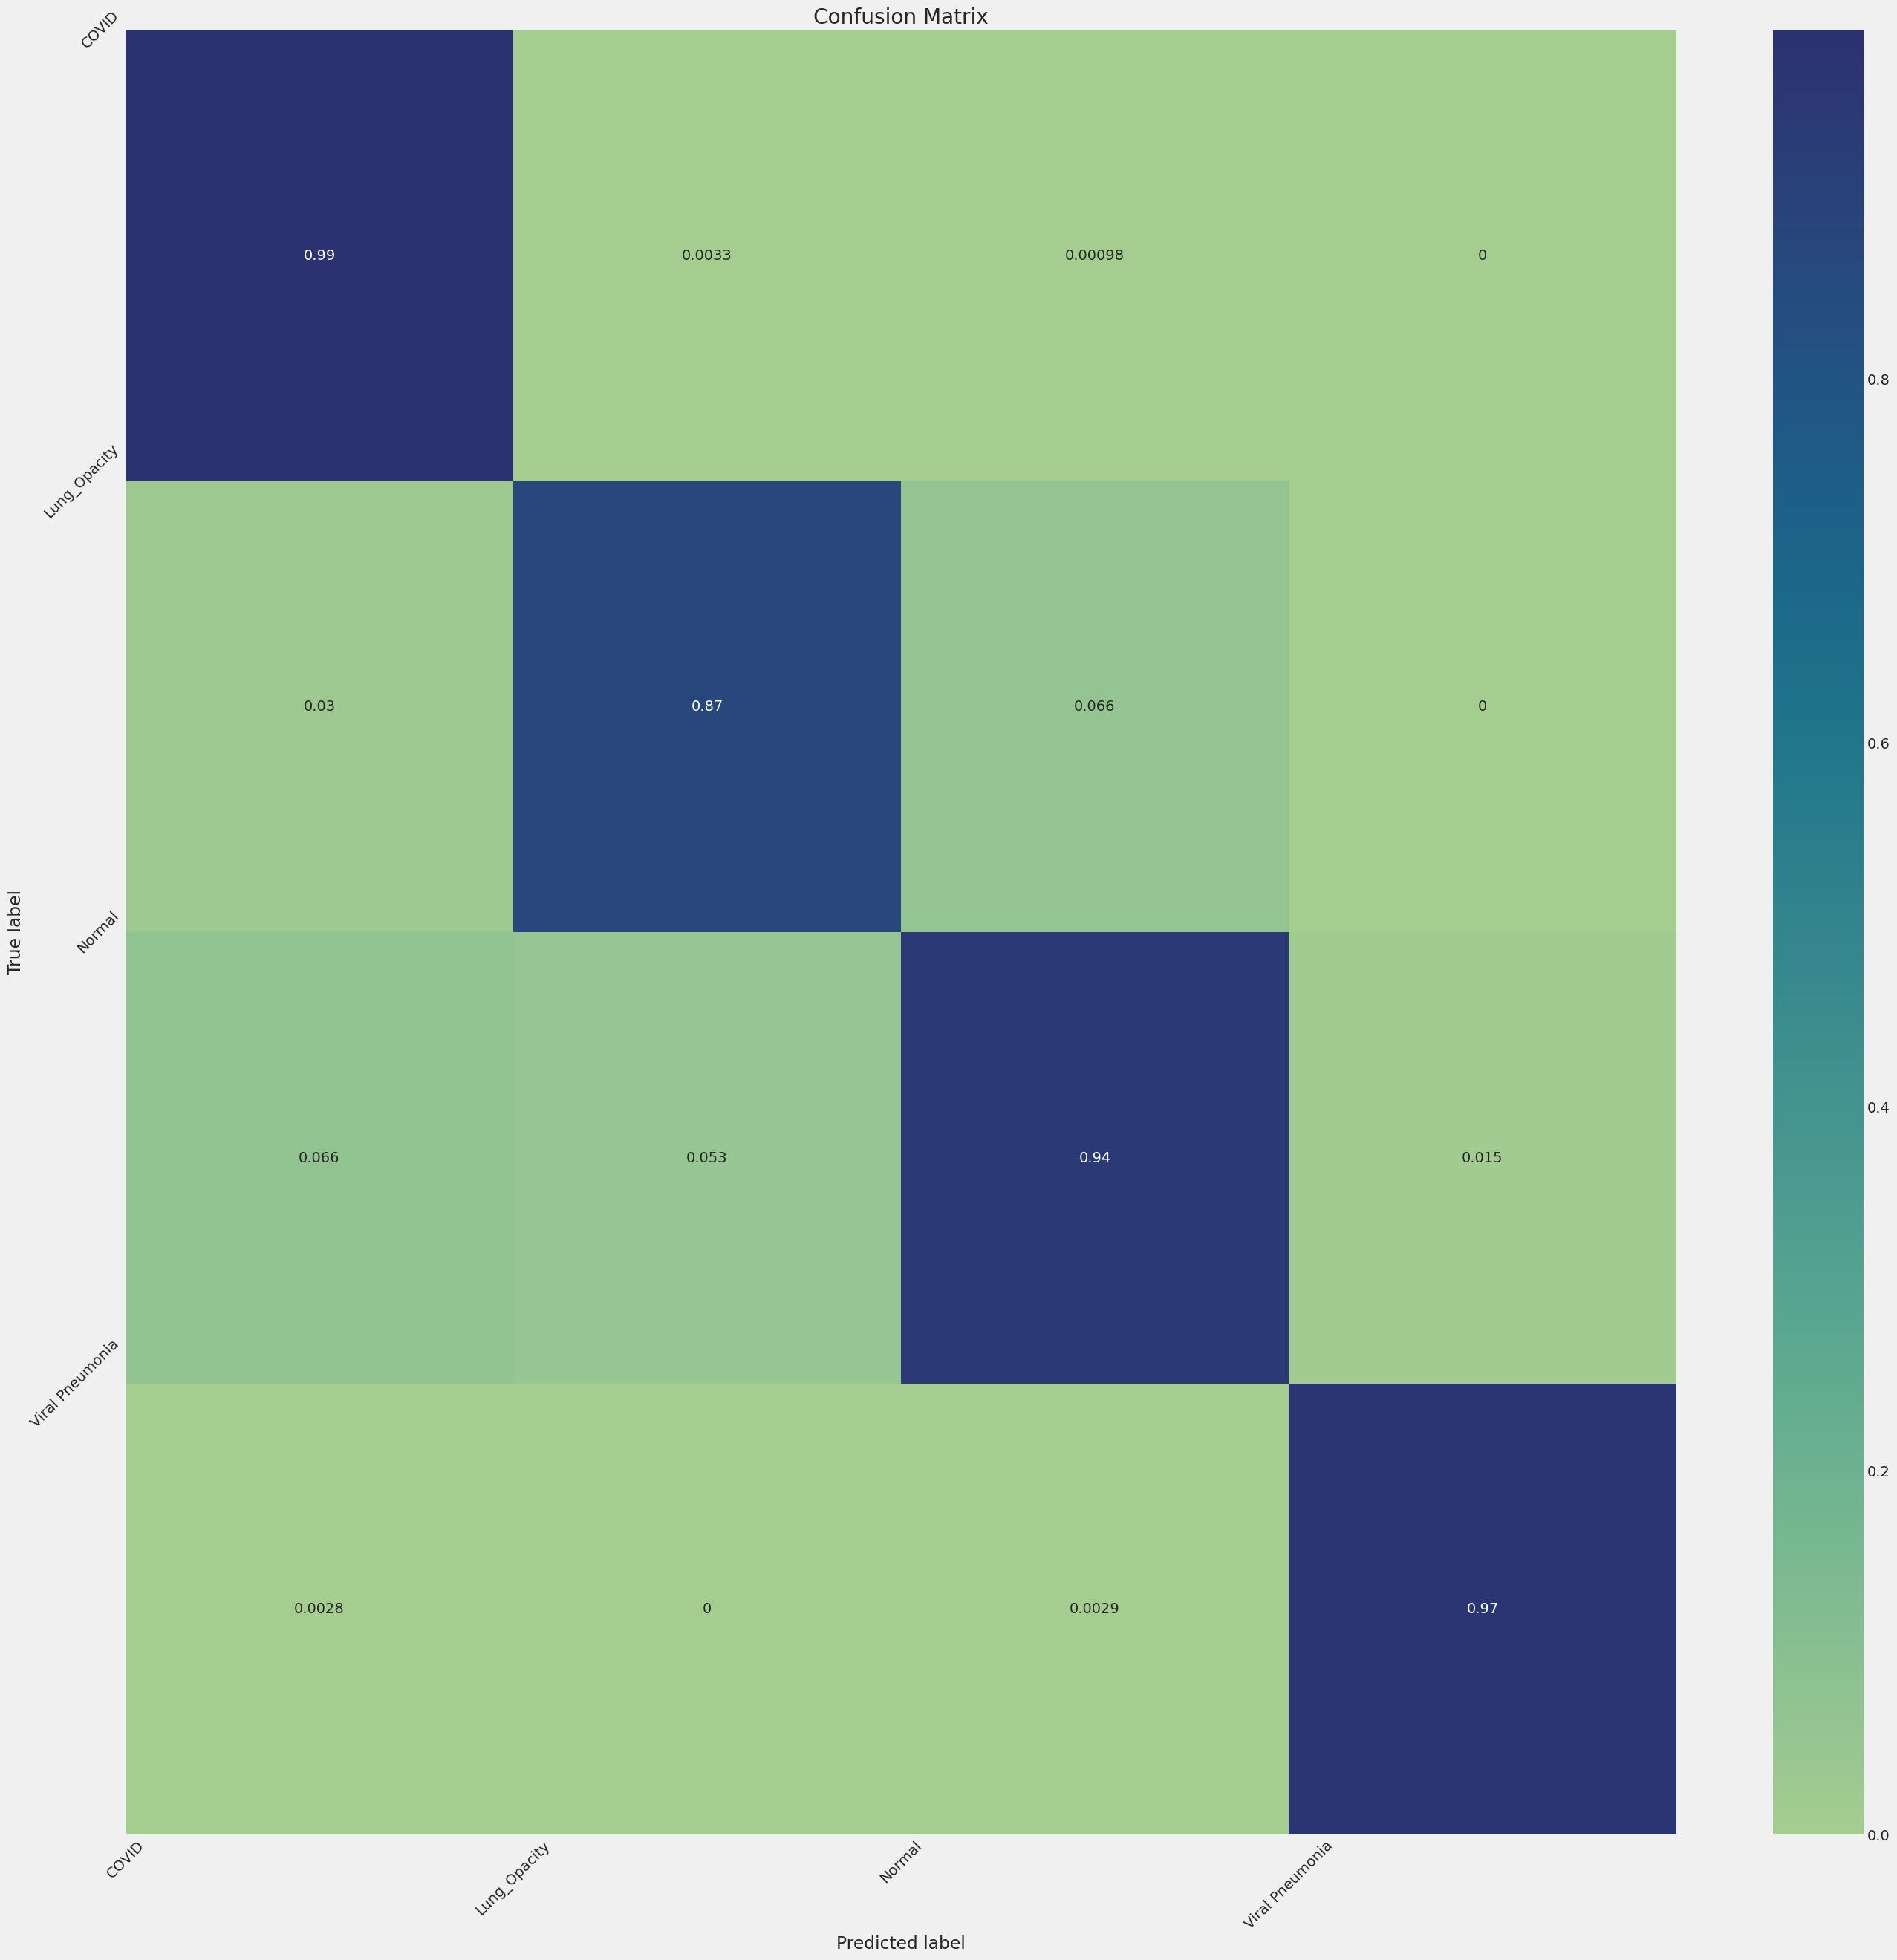

In [37]:
confusion_matrix_plot(y_true, y_pred, figsize=(30,30))

In [38]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

29/29 [==============================] - 8s 264ms/step - loss: 0.2356 - accuracy: 0.9325
Train Loss:  0.11132115125656128
Train Accuracy:  0.9612069129943848
--------------------
Validation Loss:  0.191382497549057
Validation Accuracy:  0.9396551847457886
--------------------
Test Loss:  0.23559357225894928
Test Accuracy:  0.932451605796814


In [39]:
class_names = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

In [53]:
pr = []
for i in y_pred:
  pr.append(class_names[i])

print(pr)

['Normal', 'Lung_Opacity', 'Lung_Opacity', 'Lung_Opacity', 'Viral Pneumonia', 'Lung_Opacity', 'COVID', 'Viral Pneumonia', 'Lung_Opacity', 'Normal', 'Lung_Opacity', 'COVID', 'Normal', 'Viral Pneumonia', 'COVID', 'Normal', 'Normal', 'Normal', 'COVID', 'Normal', 'Lung_Opacity', 'Lung_Opacity', 'Viral Pneumonia', 'Lung_Opacity', 'Normal', 'Normal', 'Normal', 'Normal', 'COVID', 'Normal', 'Lung_Opacity', 'Normal', 'Lung_Opacity', 'Viral Pneumonia', 'COVID', 'Lung_Opacity', 'Normal', 'COVID', 'Normal', 'COVID', 'Normal', 'Normal', 'COVID', 'Lung_Opacity', 'COVID', 'Normal', 'Normal', 'Viral Pneumonia', 'Normal', 'Normal', 'COVID', 'Lung_Opacity', 'COVID', 'Viral Pneumonia', 'Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia', 'Normal', 'Lung_Opacity', 'Lung_Opacity', 'Lung_Opacity', 'Normal', 'Lung_Opacity', 'Normal', 'Normal', 'Normal', 'Lung_Opacity', 'Lung_Opacity', 'Normal', 'Lung_Opacity', 'Normal', 'Lung_Opacity', 'Normal', 'Normal', 'Normal', 'Lung_Opacity', 'COVID', 'Normal', 'Normal

In [54]:
tr = []
for i in y_true:
  tr.append(class_names[i])

print(tr)

['Lung_Opacity', 'Lung_Opacity', 'Lung_Opacity', 'Normal', 'Viral Pneumonia', 'Normal', 'COVID', 'Viral Pneumonia', 'Normal', 'Normal', 'Lung_Opacity', 'COVID', 'Normal', 'Viral Pneumonia', 'COVID', 'Normal', 'Normal', 'Normal', 'COVID', 'Normal', 'Lung_Opacity', 'Lung_Opacity', 'Viral Pneumonia', 'Lung_Opacity', 'Normal', 'Normal', 'Normal', 'Normal', 'COVID', 'Normal', 'Lung_Opacity', 'Normal', 'Lung_Opacity', 'Viral Pneumonia', 'COVID', 'Lung_Opacity', 'Normal', 'COVID', 'Normal', 'Normal', 'Normal', 'Normal', 'COVID', 'Lung_Opacity', 'COVID', 'Normal', 'Viral Pneumonia', 'Viral Pneumonia', 'Normal', 'Normal', 'COVID', 'Lung_Opacity', 'COVID', 'Viral Pneumonia', 'Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia', 'Normal', 'Lung_Opacity', 'Lung_Opacity', 'Lung_Opacity', 'Normal', 'Lung_Opacity', 'Normal', 'Normal', 'Normal', 'Lung_Opacity', 'Lung_Opacity', 'Normal', 'Lung_Opacity', 'Normal', 'Lung_Opacity', 'Normal', 'Normal', 'Normal', 'Lung_Opacity', 'COVID', 'Normal', 'Normal',

In [68]:
i = 0
while i in (0, len(pr)):
  print(f"predicted {pr[i]}, true {tr[i]}")
  i = i + 1

predicted Normal, true Lung_Opacity


In [40]:
import PIL
from PIL import Image, ImageOps
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input

In [41]:
def image_loader(file):
  # Load the image using PIL
  img = image.load_img(file, target_size=(224, 224))
  # Convert the image to a numpy array
  img_array = image.img_to_array(img)
  # Add an extra dimension to represent the batch size
  img_array = np.expand_dims(img_array, axis=0)

  # Preprocess the image
  preprocessed_img = preprocess_input(img_array)

  return preprocessed_img

In [42]:
img = Image.open('/content/pneuomonia.jpeg')

In [59]:
iMage = image_loader('/content/lo.png')

In [60]:
def load_and_predict(image_reshaped, model):
  #image_reshaped = image[np.newaxis, ...]
  prediction = model.predict(image_reshaped)

  return prediction

In [61]:
pred = load_and_predict(iMage, model)

1/1 [==============================] - 0s 24ms/step


In [62]:
print(class_names[np.argmax(pred)])

Lung_Opacity


In [63]:
model_name = model.input_names[0][:-6]
subject = 'Disease'
acc = test_score[1] * 100
save_path = ''

# Save model
save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

# Save weights
weight_save_id = str(f'{model_name}-{subject}-weights.h5')
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')

model was saved as resnet50-Disease-93.25.h5
weights were saved as resnet50-Disease-weights.h5
